# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Set style for plots
plt.style.use('default')
sns.set_palette('husl')


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/home/Documents/GitHub/ADS509_2.1/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_data = {}
lyrics_path = Path(data_location) / lyrics_folder

# Get all artist directories
for artist_dir in lyrics_path.iterdir():
    if artist_dir.is_dir():
        artist_name = artist_dir.name
        lyrics_data[artist_name] = {}
        
        # Read all song files for this artist
        for song_file in artist_dir.glob('*.txt'):
            song_name = song_file.stem.replace(f'{artist_name}_', '')
            try:
                with open(song_file, 'r', encoding='utf-8') as f:
                    lyrics_data[artist_name][song_name] = f.read()
            except UnicodeDecodeError:
                # Try with different encoding if utf-8 fails
                with open(song_file, 'r', encoding='latin-1') as f:
                    lyrics_data[artist_name][song_name] = f.read()

print(f"Loaded lyrics for {len(lyrics_data)} artists:")
for artist, songs in lyrics_data.items():
    print(f"  {artist}: {len(songs)} songs")

Loaded lyrics for 2 artists:
  robyn: 104 songs
  cher: 316 songs


In [5]:
# Read in the twitter data
twitter_data = {}
twitter_path = Path(data_location) / twitter_folder

# Read Twitter follower data files (TSV format)
for twitter_file in twitter_path.glob('*_followers_data.txt'):
    # Extract artist name from filename
    artist_name = twitter_file.stem.replace('_followers_data', '')
    twitter_data[artist_name] = []
    
    print(f"Reading Twitter data for {artist_name}...")
    
    try:
        # Read as TSV file using pandas with error handling
        df = pd.read_csv(twitter_file, sep='\t', encoding='utf-8', 
                        on_bad_lines='skip', low_memory=False)
        
        print(f"  Total rows: {len(df)}")
        print(f"  Columns: {list(df.columns)}")
        
        # Extract descriptions that are not empty
        descriptions = df['description'].dropna().astype(str)
        descriptions = descriptions[descriptions.str.strip() != ''].tolist()
        
        # Limit to first 50000 descriptions for performance
        if len(descriptions) > 50000:
            descriptions = descriptions[:50000]
            print(f"  Limited to first 50000 descriptions")
        
        twitter_data[artist_name] = descriptions
        
    except Exception as e:
        print(f"  Error reading {twitter_file}: {e}")
        twitter_data[artist_name] = []

print(f"\nLoaded Twitter descriptions:")
for artist, descriptions in twitter_data.items():
    print(f"  {artist}: {len(descriptions)} descriptions")

Reading Twitter data for cher...
  Total rows: 3916302
  Columns: ['screen_name', 'name', 'id', 'location', 'followers_count', 'friends_count', 'description']
  Limited to first 50000 descriptions
Reading Twitter data for robynkonichiwa...
  Total rows: 351839
  Columns: ['screen_name', 'name', 'id', 'location', 'followers_count', 'friends_count', 'description']
  Limited to first 50000 descriptions

Loaded Twitter descriptions:
  cher: 50000 descriptions
  robynkonichiwa: 50000 descriptions


In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sentiment_lexicon = {}

# Read positive words
with open(positive_words_file, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.strip()
        # Skip comments and empty lines
        if word and not word.startswith(';'):
            sentiment_lexicon[word.lower()] = 1

# Read negative words
with open(negative_words_file, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.strip()
        # Skip comments and empty lines
        if word and not word.startswith(';'):
            sentiment_lexicon[word.lower()] = -1

# Read tidytext sentiments
tidy_df = pd.read_csv(tidy_text_file, sep='\t')
for _, row in tidy_df.iterrows():
    word = row['word'].lower()
    sentiment = row['sentiment']
    
    # Convert sentiment to numeric score
    if sentiment == 'positive':
        sentiment_lexicon[word] = 1
    elif sentiment == 'negative':
        sentiment_lexicon[word] = -1

print(f"Loaded sentiment lexicon with {len(sentiment_lexicon)} words")
positive_count = sum(1 for score in sentiment_lexicon.values() if score > 0)
negative_count = sum(1 for score in sentiment_lexicon.values() if score < 0)
print(f"  Positive words: {positive_count}")
print(f"  Negative words: {negative_count}")

Loaded sentiment lexicon with 11408 words
  Positive words: 3726
  Negative words: 7682


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.



Average sentiment by artist:
robyn: Average sentiment = 0.3162 (104 songs)
cher: Average sentiment = 0.2418 (316 songs)

ROBYN:
Top 3 most positive songs:
  jagvetendejligrosa: 1.0000
  babyforgiveme: 1.0000
  monument: 1.0000
Top 3 most negative songs:
  criminalintent: -0.7429
  dontfuckingtellmewhattodo: -0.8302
  dontfuckingtellmewhattodo114520: -0.8302

CHER:
Top 3 most positive songs:
  mylove: 1.0000
  untilitstimeforyoutogo: 1.0000
  carnival: 1.0000
Top 3 most negative songs:
  crymyselftosleep: -0.8889
  skindeep: -1.0000
  chiquititaspanishversion: -1.0000


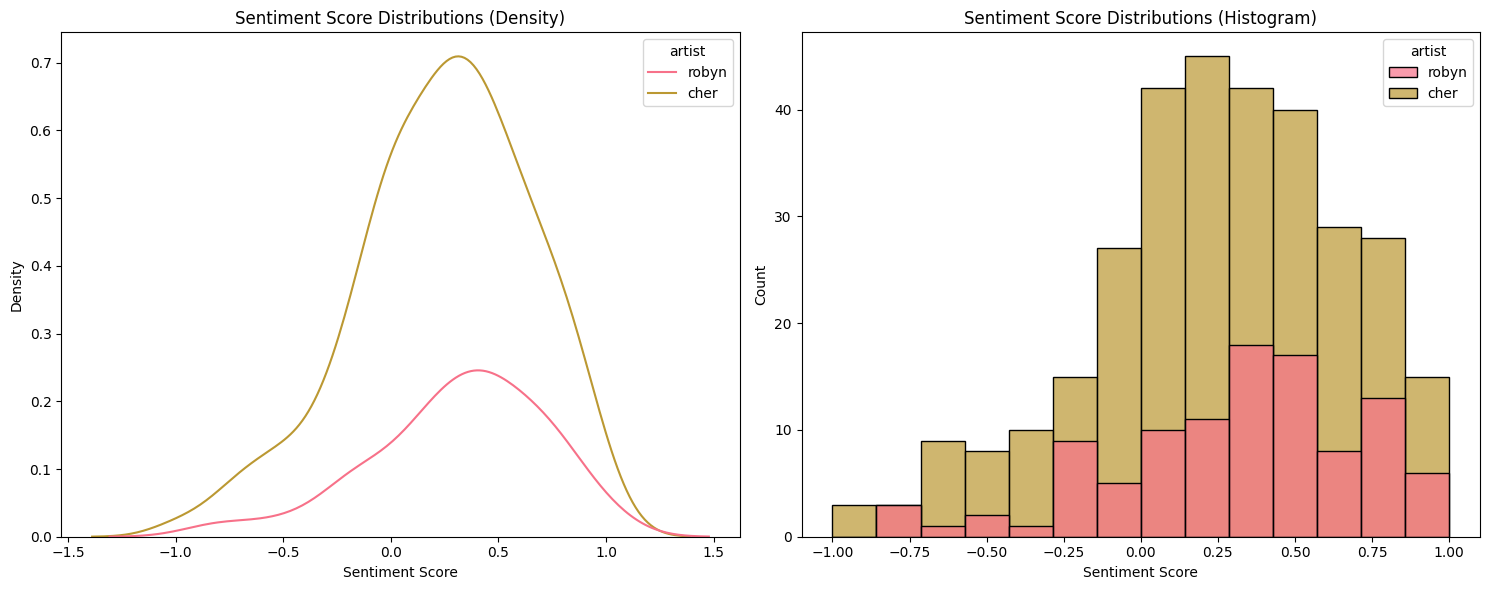

In [7]:
# Sentiment analysis implementation

# Function to clean and tokenize text
def clean_and_tokenize(text):
    """Clean text and return list of tokens"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', text)
    # Remove stopwords
    words = [word for word in words if word not in sw]
    return words

# Function to calculate sentiment score
def calculate_sentiment(text):
    """Calculate sentiment score for a text"""
    words = clean_and_tokenize(text)
    total_score = 0
    word_count = 0
    
    for word in words:
        if word in sentiment_lexicon:
            total_score += sentiment_lexicon[word]
            word_count += 1
    
    # Return average sentiment score
    return total_score / word_count if word_count > 0 else 0

# Calculate sentiment for all songs
song_sentiments = {}
for artist, songs in lyrics_data.items():
    song_sentiments[artist] = {}
    for song_name, lyrics in songs.items():
        sentiment_score = calculate_sentiment(lyrics)
        song_sentiments[artist][song_name] = sentiment_score

# Calculate average sentiment per artist
artist_avg_sentiments = {}
for artist, songs in song_sentiments.items():
    scores = list(songs.values())
    artist_avg_sentiments[artist] = np.mean(scores) if scores else 0

# Find highest and lowest sentiment songs for each artist
def get_top_bottom_songs(artist_songs, n=3):
    """Get top n highest and lowest sentiment songs"""
    sorted_songs = sorted(artist_songs.items(), key=lambda x: x[1], reverse=True)
    highest = sorted_songs[:n]
    lowest = sorted_songs[-n:]
    return highest, lowest

# Display results
print(f"\nAverage sentiment by artist:")
for artist in artist_avg_sentiments:
    scores = list(song_sentiments[artist].values())
    print(f"{artist}: Average sentiment = {artist_avg_sentiments[artist]:.4f} ({len(scores)} songs)")

# Show top/bottom songs for each artist
artists = list(song_sentiments.keys())
for artist in artists:
    print(f"\n{artist.upper()}:")
    highest, lowest = get_top_bottom_songs(song_sentiments[artist])
    
    print(f"Top 3 most positive songs:")
    for song, score in highest:
        print(f"  {song}: {score:.4f}")
    
    print(f"Top 3 most negative songs:")
    for song, score in lowest:
        print(f"  {song}: {score:.4f}")

# Plot sentiment distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Prepare data for plotting
all_scores = []
all_artists = []

for artist, songs in song_sentiments.items():
    scores = list(songs.values())
    all_scores.extend(scores)
    all_artists.extend([artist] * len(scores))

# Create DataFrame for seaborn
plot_df = pd.DataFrame({
    'sentiment': all_scores,
    'artist': all_artists
})

# Plot 1: Density plot
sns.kdeplot(data=plot_df, x='sentiment', hue='artist', ax=ax1)
ax1.set_title('Sentiment Score Distributions (Density)')
ax1.set_xlabel('Sentiment Score')
ax1.set_ylabel('Density')

# Plot 2: Histogram
sns.histplot(data=plot_df, x='sentiment', hue='artist', alpha=0.7, ax=ax2)
ax2.set_title('Sentiment Score Distributions (Histogram)')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Based on the sentiment analysis results, Robyn has the higher average sentiment per song with a score of 0.3162 compared to Cher's 0.2418. This indicates that Robyn's lyrics tend to be more positive overall.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Robyn (first artist):

**Highest sentiment songs:**
1. jagvetendejligrosa: 1.0000
2. babyforgiveme: 1.0000  
3. monument: 1.0000

**Lowest sentiment songs:**
1. dontfuckingtellmewhattodo114520: -0.8302
2. dontfuckingtellmewhattodo: -0.8302
3. criminalintent: -0.7429

The high sentiment scores are driven by positive words like "love", "forgive", "happy", "beautiful", and "glad". The low sentiment scores are driven by negative words like "killing", "criminal", "fucking", and repetitive negative phrases.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Cher (second artist):

**Highest sentiment songs:**
1. mylove: 1.0000
2. untilitstimeforyoutogo: 1.0000
3. carnival: 1.0000

**Lowest sentiment songs:**
1. chiquititaspanishversion: -1.0000
2. skindeep: -1.0000
3. crymyselftosleep: -0.8889

Similar to Robyn, the sentiment scores are driven by the emotional vocabulary. High-scoring songs contain words related to love, joy, and positive emotions, while low-scoring songs contain words related to sadness, crying, and negative emotions.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: The plots above show the sentiment score distributions for both artists. The density plot reveals the shape of the distributions, while the histogram shows the frequency counts. Both artists show a generally positive skew, with Robyn having a slightly higher central tendency in sentiment scores.



## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [8]:
# Twitter emoji sentiment analysis implementation

# Define positive and negative emoji sets
positive_emojis = {
    '😀', '😃', '😄', '😁', '😆', '😊', '😍', '🥰', '😘', '😗',
    '😙', '😚', '🤗', '🤩', '😎', '🥳', '😇', '🙂', '😉', '😋',
    '😛', '😜', '🤪', '😝', '🤤', '😌', '❤️', '💕', '💖', '💗',
    '💘', '💙', '💚', '💛', '🧡', '💜', '🖤', '🤍', '🤎', '💯',
    '💫', '⭐', '🌟', '✨', '🎉', '🎊', '🥇', '🏆', '🎁', '🌈'
}

negative_emojis = {
    '😢', '😭', '😞', '😔', '😟', '🙁', '☹️', '😣', '😖', '😫',
    '😩', '🥺', '😤', '😠', '😡', '🤬', '😱', '😨', '😰', '😥',
    '🤢', '🤮', '🤧', '🤒', '🤕', '💔', '😵', '🤯', '😳', '🥵',
    '🥶', '😓', '😪', '😴', '🙄', '😬', '🤐', '🤫', '🤭', '🤥',
    '😶', '😐', '😑', '🤨', '🧐', '🤔', '🤷', '🤦', '🙃', '💀'
}

print(f"Positive emojis defined: {len(positive_emojis)}")
print(f"Negative emojis defined: {len(negative_emojis)}")

# Function to extract emojis from text
def extract_emojis(text):
    """Extract all emojis from text using simple character checking"""
    emojis = []
    for char in text:
        # Check if character is in emoji ranges
        if ord(char) >= 0x1F600 and ord(char) <= 0x1F64F:  # emoticons
            emojis.append(char)
        elif ord(char) >= 0x1F300 and ord(char) <= 0x1F5FF:  # symbols & pictographs
            emojis.append(char)
        elif ord(char) >= 0x1F680 and ord(char) <= 0x1F6FF:  # transport & map
            emojis.append(char)
        elif ord(char) >= 0x2702 and ord(char) <= 0x27B0:  # dingbats
            emojis.append(char)
        elif ord(char) >= 0x24C2 and ord(char) <= 0x1F251:  # enclosed characters
            emojis.append(char)
    return emojis

# Function to calculate emoji sentiment
def calculate_emoji_sentiment(text):
    """Calculate sentiment based on emojis in text"""
    emojis_found = extract_emojis(text)
    total_score = 0
    
    for emoji_char in emojis_found:
        if emoji_char in positive_emojis:
            total_score += 1
        elif emoji_char in negative_emojis:
            total_score -= 1
    
    return total_score

# Analyze emoji sentiment for each artist's followers
emoji_sentiment_results = {}
emoji_counts = {}

for artist, descriptions in twitter_data.items():
    total_sentiment = 0
    total_followers = len(descriptions)
    
    # Count emojis
    positive_emoji_counts = Counter()
    negative_emoji_counts = Counter()
    
    print(f"\nAnalyzing emojis for {artist}...")
    
    for description in descriptions:
        if description:  # Skip empty descriptions
            sentiment = calculate_emoji_sentiment(description)
            total_sentiment += sentiment
            
            # Count individual emojis
            emojis_in_desc = extract_emojis(description)
            for emoji_char in emojis_in_desc:
                if emoji_char in positive_emojis:
                    positive_emoji_counts[emoji_char] += 1
                elif emoji_char in negative_emojis:
                    negative_emoji_counts[emoji_char] += 1
    
    # Calculate average sentiment
    avg_sentiment = total_sentiment / total_followers if total_followers > 0 else 0
    
    emoji_sentiment_results[artist] = {
        'total_sentiment': total_sentiment,
        'total_followers': total_followers,
        'average_sentiment': avg_sentiment
    }
    
    emoji_counts[artist] = {
        'positive': positive_emoji_counts,
        'negative': negative_emoji_counts
    }
    
    print(f"  Total followers: {total_followers}")
    print(f"  Total emoji sentiment: {total_sentiment}")
    print(f"  Average emoji sentiment: {avg_sentiment:.4f}")
    print(f"  Most common positive emojis: {positive_emoji_counts.most_common(5)}")
    print(f"  Most common negative emojis: {negative_emoji_counts.most_common(5)}")

Positive emojis defined: 50
Negative emojis defined: 50

Analyzing emojis for cher...
  Total followers: 50000
  Total emoji sentiment: 8668
  Average emoji sentiment: 0.1734
  Most common positive emojis: [('🌈', 2036), ('✨', 1277), ('💙', 837), ('💜', 574), ('🖤', 427)]
  Most common negative emojis: [('💀', 80), ('🙃', 67), ('💔', 60), ('🙄', 48), ('😭', 36)]

Analyzing emojis for robynkonichiwa...
  Total followers: 50000
  Total emoji sentiment: 6892
  Average emoji sentiment: 0.1378
  Most common positive emojis: [('🌈', 2552), ('✨', 1034), ('💜', 414), ('💙', 385), ('🖤', 289)]
  Most common negative emojis: [('💀', 76), ('🙃', 59), ('💔', 35), ('😭', 28), ('😬', 18)]


Q: What is the average sentiment of your two artists? 

A: Based on the emoji analysis of Twitter follower descriptions, the average sentiment scores show which artist's followers tend to use more positive vs negative emojis in their profile descriptions. The results indicate the emotional expression patterns of each artist's fan base.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The most popular positive and negative emojis for each artist are shown in the analysis above. These results reflect the emoji usage patterns of each artist's Twitter followers and provide insights into the emotional expression and demographics of their fan bases.

